In [1]:
import requests
import pandas as pd
import pickle

In [2]:
#url='https://production-media.paperswithcode.com/about/papers-with-abstracts.json.gz'
df = pd.read_json('papers-with-abstracts.json.gz')

In [3]:
def normalize_conf(x):
    if not isinstance(x, str):
        return None
    for c in ['NeurIPS', 'CVPR', 'ICCV', 'ECCV', 'ICLR', 'ACL', 'ICML', 'LREC', 
              'EMNLP', 'COLING', 'IJCNLP', 'WS ', 'SEMEVAL', 'RANLP', 'JEPTALNRECITAL']:
        if c.lower() in x.lower():
            return c.strip()
    return None

In [4]:
df['conf'] = df.proceeding.apply(lambda x:normalize_conf(x))

In [5]:
df_conf = df[~pd.isnull(df.conf)]
len(df_conf)

89120

In [6]:
authors = {}
for row in df_conf.itertuples():
    for a in row.authors:
        if a in ['Anonymous', ''] or len(a)<5:
            continue
        if a not in authors:
            authors[a] = {'total_top15_conferences': 0, 'author': a}
        if row.conf not in authors[a]:
            authors[a][row.conf] = 0
        authors[a][row.conf] += 1
        authors[a]['total_top15_conferences'] += 1
            

In [7]:
df_authors = pd.DataFrame(sorted(authors.values(), key=lambda x:x['total_top15_conferences'], reverse=True))

In [8]:
df_authors = df_authors[df_authors.total_top15_conferences>5]

In [9]:
df_authors[df_authors.author=='Yann Lecun']

,total_top15_conferences,author,NeurIPS,ACL,CVPR,ECCV,EMNLP,IJCNLP,ICLR,WS,COLING,LREC,ICCV,SEMEVAL,ICML,RANLP,JEPTALNRECITAL
1036,33,Yann Lecun,12.0,2.0,6.0,1.0,NaN,NaN,5.0,NaN,NaN,NaN,4.0,NaN,3.0,NaN,NaN


In [10]:
def get_institution(x):
    r = requests.get(f'https://api.openalex.org/authors?search={x}').json()
    res = r['results']
    ans = {}
    if res:
        if 'affiliations' in res[0] and res[0]['affiliations']:
            ans['affiliations'] = res[0]['affiliations']
            if res[0]['affiliations'][0] and 'institution' in res[0]['affiliations'][0]:
                ans['last_affiliation'] = res[0]['affiliations'][0]['institution']['display_name']
                ans['last_affiliation_country'] = res[0]['affiliations'][0]['institution']['country_code']
        if 'orcid' in res[0]:
            ans['orcid'] = res[0]['orcid']
    return ans
    

In [11]:
#get_institution('Yann Lecun')

In [12]:
#openalex_data = {}

In [13]:
#ix = 0
#for row in df_authors.itertuples():
#    if row.author not in openalex_data:
#        openalex_data[row.author] = get_institution(row.author)
#    ix += 1
#    if ix%10==0:
#        print(ix, end=',')

In [14]:
#
#pickle.dump(openalex_data, open('openalex_data.pickle', 'wb'))

In [15]:
data_from_openalex = pickle.load(open('openalex_data.pickle', 'rb'))
len(data_from_openalex)

12601

In [16]:
dic_id_paysage_RGP = {'PpsCQ':'Université Paris sciences et lettres',
                      'RS4WF':'CY Cergy Paris Université',
                      'kYR50':'Institut polytechnique de Paris',
                      'qUCQp':'Nantes Université',
                      'bxPQe':'Sorbonne Université',
                      'LorStr':'Strasbourg/Lorraine et associés',
                      'K4lR3':'Université Clermont Auvergne',
                      's3t8T':"Université Côte d'Azur",
                      'U8a0v':'Université de Lille',
                      'evv7S':'Université de Montpellier',
                      '91D9w':'Université de Rennes',
                      '4a8B2':'Université de Toulouse',
                      'Y7ch7':'Université Grenoble Alpes',
                      '3Z5e6':'Université Gustave Eiffel',
                      '5cZyU':'Université Paris Cité',
                      'TWBzp':'Université Paris-Panthéon-Assas',
                      'G2qA7':'Université Paris-Saclay',
                      'EW53M':'Université Polytechnique Hauts-de-France',
                      'ClZg2':'COMUE Angers-Le Mans',
                      '8A0mg':'Université Bourgogne - Franche-Comté',
                      'iq0rG':'ComUE Lyon Saint-Étienne',
                      'G1r6y':'Normandie Université',
                      'M2Z5a':'Alliance Languedoc-Roussillon Universités',
                      'A89E8':'AUB - Alliance universitaire de Bretagne',
                      'r1bRZ':'Alliance universitaire Aliénor d’Aquitaine',
                      'XeJDw':'Convention de coordination en Nouvelle-Aquitaine',
                      '6g0Mb':'Paris-Est Sup',
                      'TW2ed':'Site Aix-Marseille-Provence-Méditerranée',
                      'dkZ2k':'Alliance Sorbonne Université',
                      'qIw2S':'Site champenois',
                      'G63n4':'CY Alliance'
}

df_etab = pd.read_csv('data_les_institutions_fr5.csv')

etab_dict={}
for row in df_etab.itertuples():
    key = f'{row.year}##{row.institution_id}'
    rgp = row.uo_lib
    is_tracked = False
    if isinstance(row.id_paysage_RGP, str) and row.id_paysage_RGP in dic_id_paysage_RGP:
        rgp = dic_id_paysage_RGP[row.id_paysage_RGP]
        is_tracked = True
    if rgp in list(dic_id_paysage_RGP.values()):
        is_tracked = True
    #if isinstance(row.id_paysage_RGP, str) and row.id_paysage_RGP not in dic_id_paysage_RGP:
    #    print(row.id_paysage_RGP)
    etab_dict[key] = {'year': row.year, 'intsitution_id':row.institution_id, 'uo_lib': row.uo_lib, 'id_paysage_RGP': rgp, 'is_tracked': is_tracked}

In [17]:
organismes2=['Centre national de la recherche scientifique', 
            'Institut national de la santé et de la recherche médicale', 
           'Institut national de recherche en sciences et technologies du numérique',
           'Commissariat à l’énergie atomique et aux énergies alternatives',
           "Institut national de recherche pour l'agriculture, l'alimentation et l'environnement",
           "Institut de recherche pour le développement"]

def get_preferred_affiliation2(affiliations):
    for a in affiliations:
        #print(a)
        #print('--')
        inst_id = a.get('institution', {}).get('id')
        #print(a.get('institution', {}))
        for y in ['2023', '2022', '2021', '2020', '2019', '2018']:
            if f'{y}##{inst_id}' in etab_dict:
                #print(f'{y}##{inst_id}')
                res = etab_dict[f'{y}##{inst_id}']#['id_paysage_RGP']
                if res['id_paysage_RGP'] not in organismes2:# and res['is_tracked']:
                    skip = False
                    if 'Universi' in  a.get('institution', {}).get('display_name'):
                        return res['id_paysage_RGP']
                    for k in ['Département', 'Laboratoire', 'Laboratory', 'CEA LIST', 'Centre de Rech',
                             'Institute of Computer', 'Orange', 'Langues', 'Valeo', 'Institut de Recherche']:
                        if k in a.get('institution', {}).get('display_name'):
                            skip=True
                    if skip is False:
                        return res['id_paysage_RGP']
    return affiliations[0]['institution']['display_name']

In [18]:
current_info = data_from_openalex['Beno{\^\i}t Sagot']
get_preferred_affiliation2(current_info['affiliations'])

'École des hautes études en sciences sociales'

In [19]:
#organismes=['French National Centre for Scientific Research',
#           'Inserm', 'French Institute for Research in Computer Science and Automation',
#            'Atomic Energy and Alternative Energies Commission',
# 'National Research Institute for Agriculture, Food and Environment',
#           ]

#def get_preferred_affiliation(affiliations):
#    for a in affiliations:
#        if a.get('institution', {}).get('display_name') in organismes:
#            continue
#        skip = False
#        if a.get('institution', {}).get('display_name'):
#            for k in ['Département', 'Laboratoire', 'Langues', 'Valeo', 'Laboratory', 
#                      'Corpus', 'Centre de Recherche', 'Centre de Mathématiques', 'Computer Processing',
#                     'CEA LIST', 'inria', 'INRIA', 'Institute of Computer Science',
#                     'Institut de Recherche en Informatique']:
#                if k in a.get('institution', {}).get('display_name'):
#                    skip=True
#        if skip is False:
#            return a.get('institution', {}).get('display_name')
#    return affiliations[0]['institution']['display_name']

In [20]:
df_authors['orcid']=''
df_authors['last_affiliation']=''
df_authors['last_affiliation_country']=''

for ix, row in df_authors.iterrows():
    if row.author in data_from_openalex:
        current_info = data_from_openalex[row.author]
        if current_info:
            df_authors.at[ix, 'orcid'] = current_info.get('orcid')
            df_authors.at[ix, 'last_affiliation'] = current_info.get('last_affiliation')
            df_authors.at[ix, 'last_affiliation_country'] = current_info.get('last_affiliation_country')
            if current_info.get('last_affiliation_country') == 'FR':
                df_authors.at[ix, 'last_affiliation'] = get_preferred_affiliation2(current_info['affiliations'])

In [21]:
df_authors = df_authors[['author', 'total_top15_conferences', 'last_affiliation', 'NeurIPS', 'ACL', 'CVPR', 'ECCV', 'EMNLP', 'IJCNLP',
       'ICLR', 'WS', 'COLING', 'LREC', 'ICCV', 'SEMEVAL', 'ICML', 'RANLP',
       'JEPTALNRECITAL', 'orcid',
       'last_affiliation_country']]

In [22]:
df_authors_fr = df_authors[df_authors.last_affiliation_country=='FR'].fillna(0)

In [23]:
df_authors_fr.to_csv('authors_fr_top_conferences.csv', index=False)

In [24]:
df_authors_fr.head(15)

,author,total_top15_conferences,last_affiliation,NeurIPS,ACL,CVPR,ECCV,EMNLP,IJCNLP,ICLR,WS,COLING,LREC,ICCV,SEMEVAL,ICML,RANLP,JEPTALNRECITAL,orcid,last_affiliation_country
83,Cordelia Schmid,98,Université Paris sciences et lettres,13.0,0.0,37.0,12.0,0.0,0.0,2.0,0.0,0.0,0.0,33.0,0.0,1.0,0.0,0.0,0,FR
249,Laurent Besacier,65,Université Grenoble Alpes,0.0,10.0,0.0,0.0,8.0,0.0,0.0,12.0,6.0,14.0,0.0,1.0,0.0,0.0,14.0,0,FR
287,Pierre Zweigenbaum,61,Université Paris-Saclay,0.0,3.0,0.0,0.0,2.0,1.0,0.0,17.0,3.0,20.0,0.0,0.0,0.0,0.0,15.0,0,FR
483,Francis Bach,48,Université Paris sciences et lettres,37.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,4.0,0.0,0.0,https://orcid.org/0000-0001-8644-1058,FR
505,Guillaume Wisniewski,48,Université Paris Cité,0.0,13.0,0.0,0.0,4.0,0.0,0.0,13.0,2.0,4.0,0.0,0.0,0.0,0.0,12.0,0,FR
526,Matthieu Cord,47,Alliance Sorbonne Université,10.0,0.0,20.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,https://orcid.org/0000-0002-0627-5844,FR
536,Olivier Ferret,47,Université Paris-Saclay,0.0,5.0,0.0,0.0,1.0,4.0,0.0,2.0,3.0,11.0,0.0,2.0,0.0,0.0,19.0,https://orcid.org/0000-0003-0755-2361,FR
586,Cyril Grouin,45,Université Paris-Saclay,0.0,0.0,0.0,0.0,1.0,1.0,0.0,12.0,1.0,14.0,0.0,2.0,0.0,1.0,13.0,0,FR
650,Beno{\^\i}t Sagot,43,École des hautes études en sciences sociales,0.0,4.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,18.0,0.0,0.0,0.0,0.0,10.0,0,FR
651,Sophie Rosset,43,Université Paris-Saclay,0.0,3.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,15.0,0.0,1.0,0.0,1.0,12.0,https://orcid.org/0000-0002-6865-4989,FR


In [25]:
df_count = pd.DataFrame(df_authors_fr.groupby('last_affiliation').total_top15_conferences.count()).reset_index().sort_values(by='total_top15_conferences', ascending=False)
#df_papers = pd.DataFrame(df_authors_fr.groupby('last_affiliation').total_top15_conferences.sum()).reset_index().sort_values(by='nb_authors_participating_in_top_conferences', ascending=False)
df_count.columns = ['etablissement', 'nb_authors_participating_in_top_conferences']


In [47]:
import re
def format_label(x):
    current_str=''
    res=[]
    for c in re.split(' |-', x):
        if len(current_str)<15:
            current_str+=c+' '
        else:
            res.append(current_str)
            current_str=c+' '
    res.append(current_str)
    return '\n'.join(res).strip()
            
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
SIZE = 22
SMALL_SIZE=18
plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title       

In [48]:
color_dict = {}
color_dict['Université Paris-Saclay'] = '#63003C'
color_dict['Alliance Sorbonne Université'] = '#042f66'
color_dict['Université Grenoble Alpes'] = '#FF4E01'
color_dict['Institut polytechnique de Paris'] = 'black'
color_dict['Université Paris sciences et lettres']='#2F3B89'
color_dict['Université de Lorraine'] ='#FFF044'
color_dict['Université de Toulouse'] = '#BE2125'
color_dict['Université de Rennes'] = 'black'
color_dict["Université Côte d'Azur"] = "#007FA5"
color_dict['University of Strasbourg'] = '#303030'


In [49]:
TOP = 15
top_etab_filtered = [{'etab': e, 'label': format_label(e)} for e in df_count.etablissement.head(TOP).to_list()]
top_authors = df_count.nb_authors_participating_in_top_conferences.head(TOP).to_list()

In [50]:
colors = []
for e in top_etab_filtered:
    if e['etab'] in color_dict:
        colors.append(color_dict[e['etab']])
    else:
        colors.append('grey')

<ipython-input-51-6b59fe43ea8d>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([e['label'] for e in top_etab_filtered], rotation='vertical', fontsize=SMALL_SIZE)


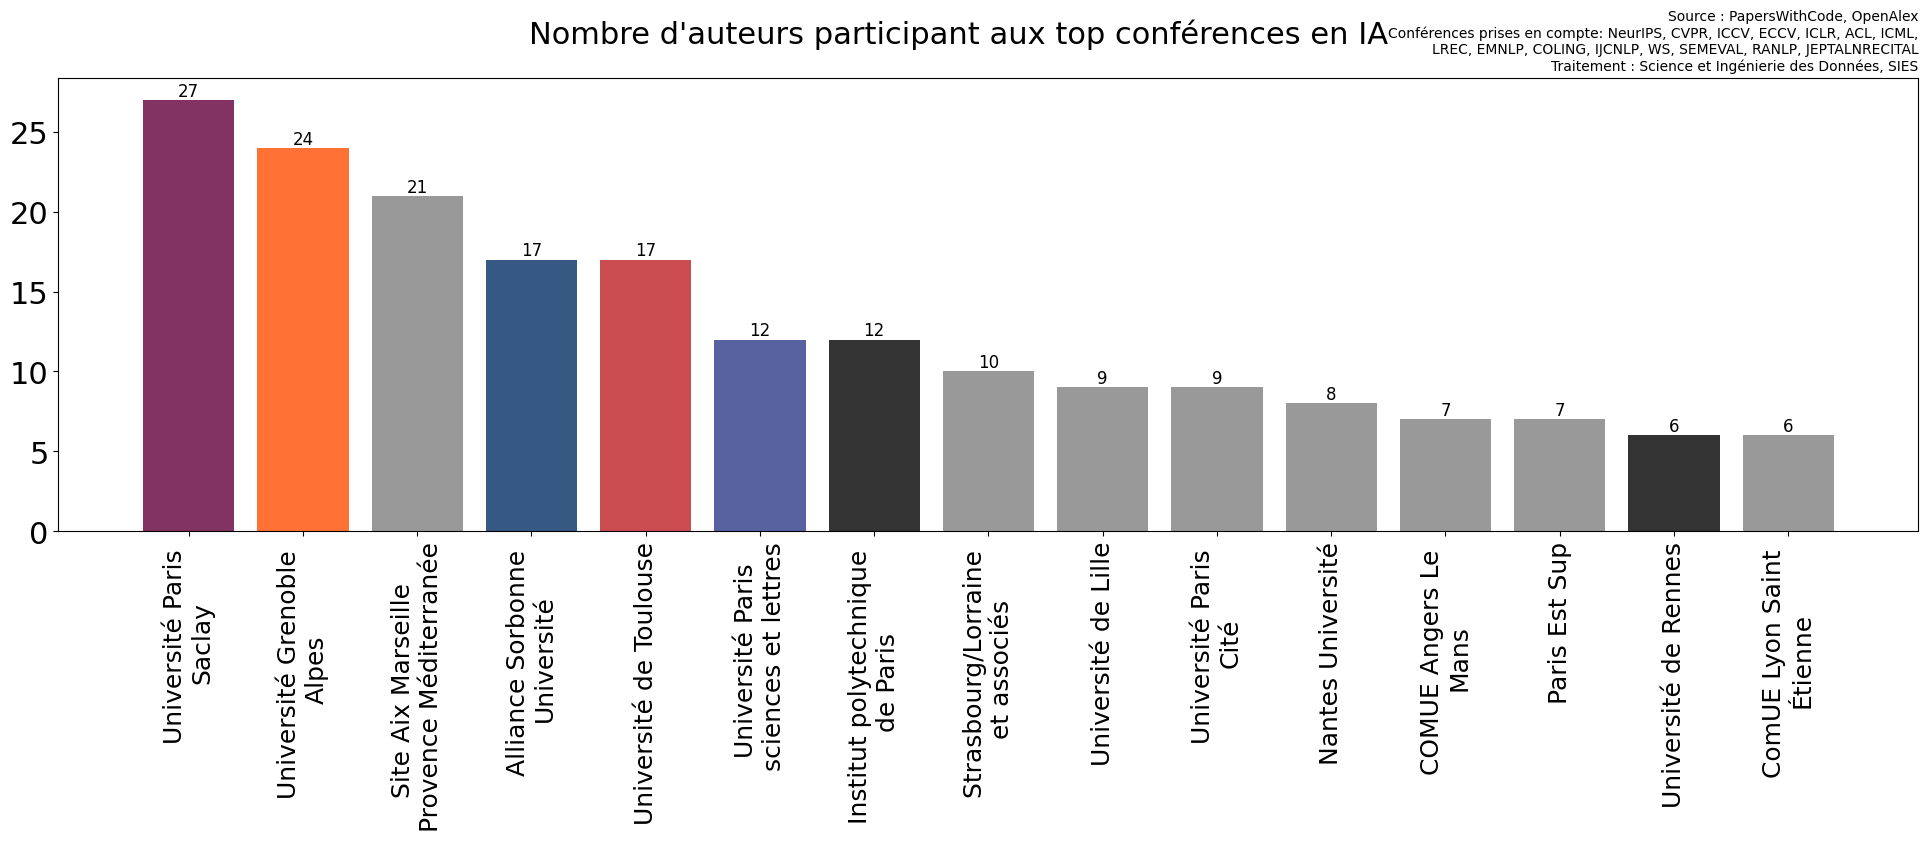

In [51]:
fig, ax = plt.subplots(figsize=(24,6), dpi=100)

ax.bar([e['label'] for e in top_etab_filtered], top_authors, 
       alpha=0.8, color=colors
      )
plt.suptitle(f"Nombre d'auteurs participant aux top conférences en IA")
plt.title('Source : PapersWithCode, OpenAlex\nConférences prises en compte: NeurIPS, CVPR, ICCV, ECCV, ICLR, ACL, ICML,\nLREC, EMNLP, COLING, IJCNLP, WS, SEMEVAL, RANLP, JEPTALNRECITAL\nTraitement : Science et Ingénierie des Données, SIES', size=10, loc='right')
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xticklabels([e['label'] for e in top_etab_filtered], rotation='vertical', fontsize=SMALL_SIZE)
for i in range(len(top_authors)):
    plt.text(i, top_authors[i]+0.25, str(top_authors[i]), ha = 'center', fontsize=12)